In [ ]:
from google.colab import drive
import math
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def better_time(df):
  # initializing the time
  cstamp = df[0]
  ctime = 0
  btime = []
  
  # initializing the timeframe variable
  tf = 1
  # iterating
  for t in range(len(df)):
    if df[t] == cstamp:
      tf += 1
    else:
      ## adding new times
      add_times = [round(ctime + i/tf,2) for i in range(1,tf+1)]
      for at in add_times:
        btime.append(at)
      ctime += 1
  return btime

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# extracting the data from csv's stored in the Propulsion Drive
# copying the exact path from the filetree
data = pd.read_csv("/content/drive/Shareddrives/General/PROPULSION/Bay Experiments/2_2-5-23/exp2.csv")
# making new time`
bt = better_time(list(data['Time Stamp']))
data['Better time (s)'] = pd.Series(bt)
time = data['Better time (s)']
# extracting the sinusoidal commutation
vph = 0.75
supplied_volts = data["Battery Volts"] * abs(data["Motor Power 1"]/1000)
freq = supplied_volts/vph
data["Enc Counter 2"] = data["Enc Counter 2"]*np.pi/800
encoderD = data["Enc Counter 2"]

plt.rcParams["figure.figsize"] = (20,3)

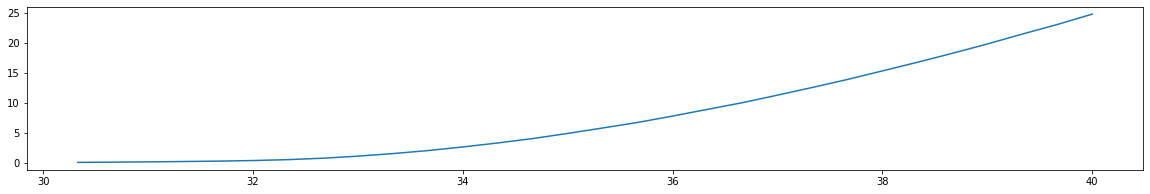

In [ ]:
plt.plot(time[90:120], encoderD[90:120])

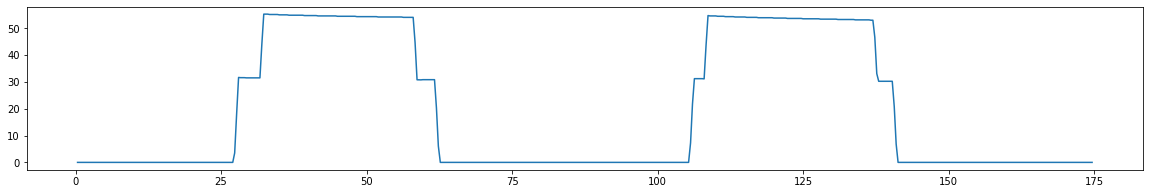

In [ ]:

plt.plot(time, freq)

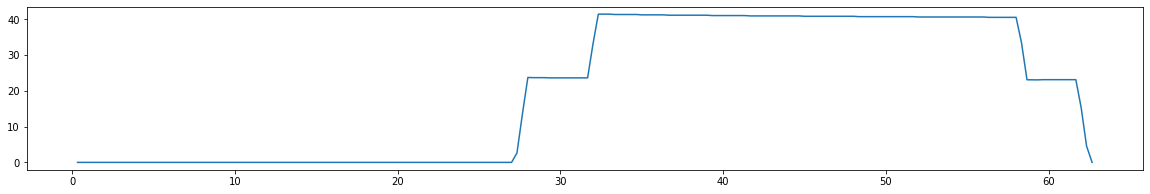

In [ ]:
plt.plot(time[:188],supplied_volts[:188])

Text(0.5, 1.0, 'Radial Velocity (RPM) vs Time (s)')

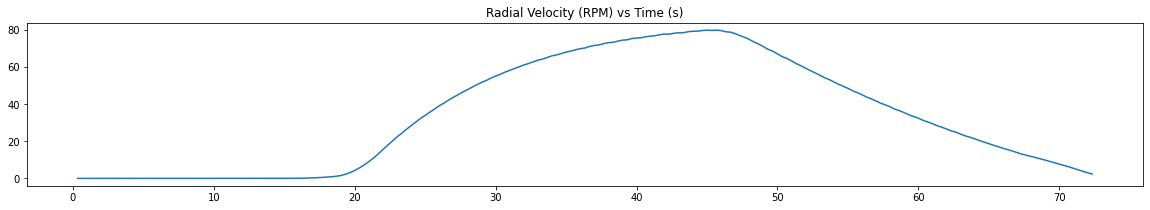

In [ ]:
# Calculating the acceleration from the data
def find_vel(x :pd.Series) -> list:
  # calculating the first derivative
  v = [] 
  xlist = list(x)
  for i in range(len(x)-1): 
    slope = (x['Enc Counter 2'].iloc[i + 1] - x['Enc Counter 2'].iloc[i])/(x['Better time (s)'].iloc[i + 1] - x['Better time (s)'].iloc[i])
    # converting slope to RPM
    v.append(slope*60/(math.pi*2))
  return v

def apply_smooth(n:list, bsize:int):
  smoothed = []
  # applying the box smoothing 
  for i in range(bsize, len(n)-bsize):
    box_start = int(i - bsize/2)
    box_end = int(i + bsize/2)
    smoothed.append(sum(n[box_start : box_end])/bsize)
  return smoothed

# calculating the raw velocity
v = find_vel(data[["Better time (s)", "Enc Counter 2"]].truncate(before=25,after=262))

plt.plot(time[:217], apply_smooth(v, 10))
plt.title("Radial Velocity (RPM) vs Time (s)") 

Text(0.5, 1.0, 'Distance (m) vs Time (s)')

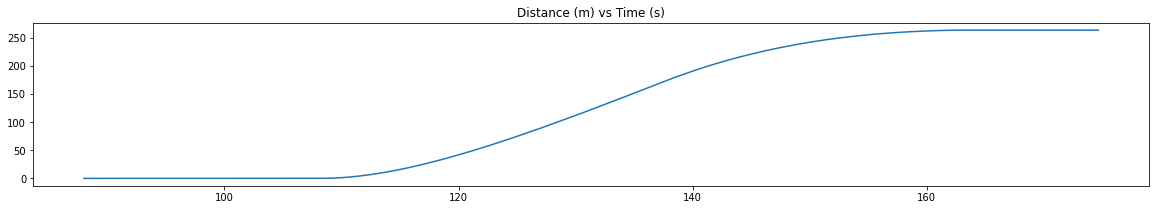

In [ ]:
plt.plot(time[263:], encoderD[263:])
plt.title("Distance (m) vs Time (s)")

Text(0.5, 1.0, 'Supplied Volts (V) vs Time (s)')

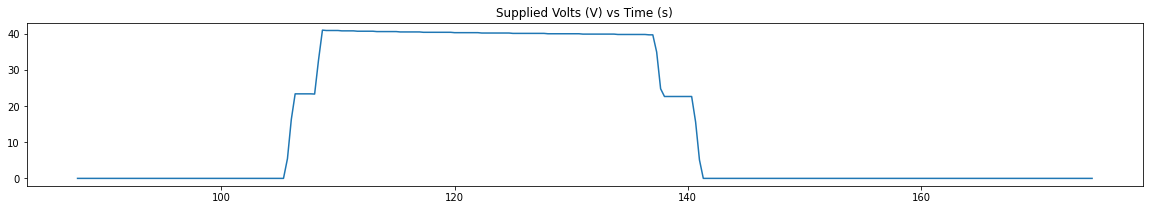

In [ ]:
plt.plot(time[262:],supplied_volts[262:])
plt.title("Supplied Volts (V) vs Time (s)")

Curve Parameters: 
Accel = 12.312*t, Duration: 18.0s -> 21.33s Delta: 3.33
Cruise = -0.046*t + 41.0 Duration: 21.33s -> 49.67s Delta: 28.34
Total time: 31.67s


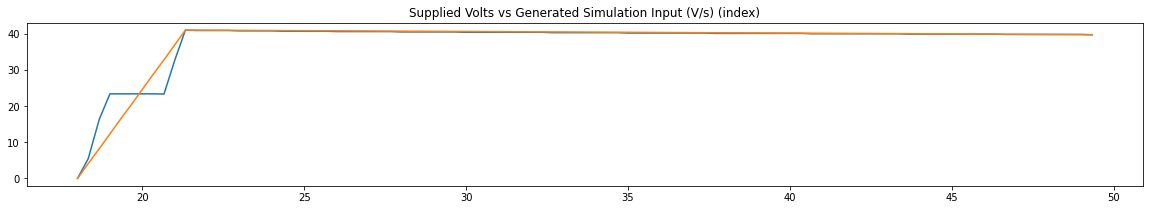

In [ ]:
# calculating input approximations

# changing the start index
svolts = supplied_volts[262:]
svolts.reset_index(drop=True, inplace=True)

start_input = 0 # timestamp 
# iterating over the rows 
for i in range(svolts.shape[0]):
  # print(cVolt, supplied_volts[i])
  if svolts[i] > 0:
    start_input = i-1
    break

# maximum supplied volts
maxVolt = 0 
maxVolti = 0 
for i in range(svolts.shape[0]):
  if maxVolt < svolts[i]:
    maxVolt = svolts[i]
    maxVolti = i

# finding the end of the cruise
end_cruise = 0 
finalVolt = 0
for i in range(maxVolti+1, svolts.shape[0]):
  # assuming slowly decreasing voltage
  if abs(svolts[i] - svolts[i-1]) > 1:
    end_cruise = i - 1
    finalVolt = svolts[i-1]
    break

# approximating the input over the actual input, with base metric 'index'
accel_slopei = round(maxVolt/(maxVolti - start_input), 3)
cruise_slopei = round((finalVolt - maxVolt) / (end_cruise - maxVolti), 3)

accel = [x*accel_slopei for x in range((maxVolti - start_input)+1)]
cruise = [x*cruise_slopei + accel[-1] for x in range((end_cruise - maxVolti) - 1)]

# graphing
plt.plot(time[start_input : end_cruise], svolts[start_input : end_cruise])
plt.plot(time[start_input : end_cruise], accel+cruise)
plt.title("Supplied Volts vs Generated Simulation Input (V/s) (index)")

# outputting the data with base-metric 'seconds'
start_accelT = data['Better time (s)'].iloc[start_input]
start_cruiseT = data['Better time (s)'].iloc[maxVolti]
end_cruiseT = data['Better time (s)'].iloc[end_cruise]

accel_slopeT = round(maxVolt/(start_cruiseT - start_accelT), 3)
cruise_slopeT = round((finalVolt-maxVolt)/(end_cruiseT - start_cruiseT), 3)

print(f"Curve Parameters: \nAccel = {accel_slopeT}*t, Duration: {start_accelT}s -> {start_cruiseT}s Delta: {round(start_cruiseT - start_accelT, 3)}")
print(f"Cruise = {cruise_slopeT}*t + {maxVolt} Duration: {start_cruiseT}s -> {end_cruiseT}s Delta: {round(end_cruiseT - start_cruiseT, 3)}")
print(f"Total time: {round(start_cruiseT - start_accelT + end_cruiseT - start_cruiseT, 3)}s")

In [ ]:
# importing simulation data
sim_speed = pd.read_csv("/content/drive/Shareddrives/General/PROPULSION/Simulations/Results/Exp 3 - 03|03|2023/speed.csv")
sim_pos = pd.read_csv("/content/drive/Shareddrives/General/PROPULSION/Simulations/Results/Exp 3 - 03|03|2023/position.csv")
sim_sv = pd.read_csv("/content/drive/Shareddrives/General/PROPULSION/Simulations/Results/Exp 3 - 03|03|2023/supplied_voltage.csv")

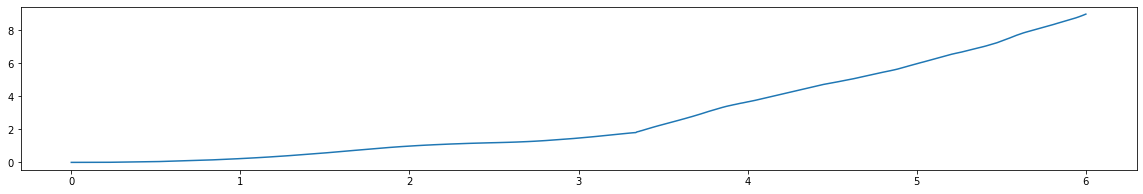

In [ ]:
plt.plot(sim_speed["Time [s]"], sim_speed["Moving1.Speed [rpm]"])

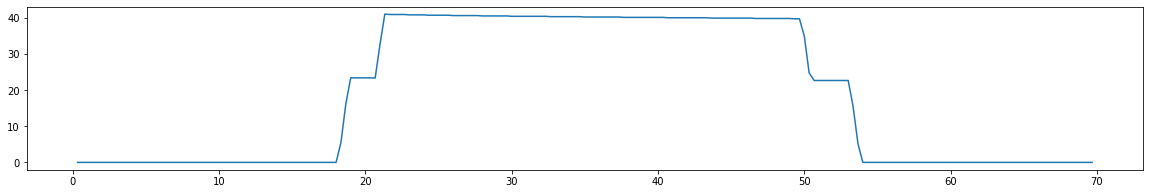

In [ ]:
plt.plot(time[:209], svolts[:209])


In [ ]:
plt.plot(sim_speed["Time [s]"], sim_speed["Moving1.Speed [rpm]"])\
# trim off the first 20 seconds, keep the 6 seconds after that
ntime, vel = FTAI(time, v, 20, 6)
plt.plot(ntime, vel)
plt.title("RPM: Simulated vs Experiment")

NameError: ignored

In [ ]:
print(len(vel))

In [ ]:
# defining some helper functions
def find_index(timeset, time):
  i = 0
  for x in timeset:
    # this should be an error approximation
    if x == time:
      return i
    i += 1 

# Front Trim Align by Index
def FTAI(time:list, variable:list, ftrim:int, btrim:int) -> tuple:
  # converting the ftrim and btrim from seconds to index
  found_index = find_index(time, ftrim)
  btrim_index = find_index(time, btrim)
  
  # trimming and aligning the datasets 
  trimmed_variable = variable[found_index : found_index + btrim_index]
  newtime = time[:len(trimmed_variable)]
  return newtime, trimmed_variable